In [8]:
from dolfinx import fem, mesh, plot, io, geometry
from dolfinx.fem.petsc import LinearProblem
from petsc4py.PETSc import ScalarType
from mpi4py import MPI
import numpy as np
from ufl import ds, dx, grad, inner
import ufl
import matplotlib as mpl
import pyvista
from typing import List, Tuple

import sys
import os
# Get the absolute path to the src directory
src_path = os.path.abspath('..')
if src_path not in sys.path:
    sys.path.append(src_path)

from src.visualization import timeDependentVariableToGif, plot_array, plot_function
from src.solutionOperators import solveStateEquation, solveAdjointEquation, getSourceTerm, buildControlFunction
from src.helpers import getValueOfFunction, buildIterationFunction, calculateL2InnerProduct
from src.semiSmoothNewtonSolver import computeSSNStep, computeObjective
from src.semiSmoothWalter import computeSSNStepWalter
from dataclasses import dataclass
from src.osqp import computeOSQPStep
from scipy import sparse

@dataclass
class Parameters:
    T = 1
    verbose = True
    dt = 0.01
    x1 = (0.5, 0.5)
    x2 = (-0.5, -0.5)
    area = 4
    d = 2
    mollify_const = 0.1
    alpha = 1e-8
    beta = 1e-8
    waveSpeed = 2
    randomFactor = 5
    maxIterations = 20
    pruneThreshold = 1e-9
    maxNewtonSteps = 50
    newton_c = 10
    yd = []
    yd_adjoint = []
    yd_firstDual = None
    yd_secondDual = None
    standardInnerProducts = None
    msh = mesh.create_rectangle(
        comm=MPI.COMM_WORLD,
        points=((-1., -1.), (1., 1.)),
        n=(64, 64),
        cell_type=mesh.CellType.triangle,
    )
    V = fem.functionspace(msh, ("Lagrange", 1))
    
class ExtremalPoint:
	def __init__(self, sigma: np.ndarray, x_0: float, type: bool, params) -> None:
		self.sigma = sigma
		self.x_0 = x_0
		self.type = type
		self.params = params
		self.idx = int(x_0/params.dt)
		self.state = self.computeState()
		if len(params.yd) > 0:
			self.standardInner = calculateL2InnerProduct(self.state, params.yd, params)

	def value(self, x):
		if (self.type == 0):
			return (np.zeros_like(self.sigma) if x < self.x_0 else self.sigma)
		else:
			if self.x_0 < self.params.T/2:
				return (self.sigma * (self.x_0 - x) if x < self.x_0 else np.zeros_like(self.sigma))
			else:
				return (self.sigma * (x - self.x_0) if x > self.x_0 else np.zeros_like(self.sigma))

	def computeState(self):
		s1 = lambda t: self.value(t)[0]
		s2 = lambda t: self.value(t)[1]
		g1 = getSourceTerm(self.params.x1, self.params)
		g2 = getSourceTerm(self.params.x2, self.params)
		control = buildControlFunction([g1, g2], [s1, s2], self.params)
		return control

class HesseMatrix:
    def __init__(self, active_set, params) -> None:
        self.params = params
        self.standard_states = self.computeStandardEntries()
        self.standard_adjoints = self.computeStandardAdjoints()
        self.active_set = []
        n = 2 * self.params.d
        self.matrix = np.zeros((n, n))
        for i, firstState in enumerate(self.standard_states):
            for j, secondState in enumerate(self.standard_states):
                self.matrix[i, j] = calculateL2InnerProduct(firstState, secondState, params)
        working_set = []
        for element in active_set:
            self.extendMatrix(element)

    def computeStandardEntries(self):
        states = []
        signal_t = lambda t: t
        signal_zero = lambda t: 0
        signal_one = lambda t: 1
        g1 = getSourceTerm(self.params.x1, self.params)
        g2 = getSourceTerm(self.params.x2, self.params)
        control = buildControlFunction([g1, g2], [signal_t, signal_zero], self.params)
        states.append(control)
        control = buildControlFunction([g1, g2], [signal_zero, signal_t], self.params)
        states.append(control)
        control = buildControlFunction([g1, g2], [signal_one, signal_zero], self.params)
        states.append(control)
        control = buildControlFunction([g1, g2], [signal_zero, signal_one], self.params)
        states.append(control)
        return states
    
    def computeStandardAdjoints(self):
        standardAdjoints = []
        for state in self.standard_states:
            standardAdjoints.append(state)
        return standardAdjoints

    def extendMatrix(self, newPoint):
        idxNewPoint = len(self.active_set)
        newRow = np.zeros(len(self.active_set) + 1 + 2 * self.params.d)
        for idx, point in enumerate(self.active_set):
            newRow[idx] = calculateL2InnerProduct(newPoint.state, point.state, self.params)
        newRow[idxNewPoint] = calculateL2InnerProduct(newPoint.state, newPoint.state, self.params)
        for idx, state in enumerate(self.standard_states):
            newRow[idxNewPoint + 1 + idx] = calculateL2InnerProduct(newPoint.state, state, self.params)
        tempRow = np.delete(newRow, idxNewPoint)
        tempMatrix = np.insert(self.matrix, idxNewPoint, tempRow, axis=0)
        self.matrix = np.insert(tempMatrix, idxNewPoint, newRow, axis=1)
        self.active_set.append(newPoint)
        
    def pruneMatrix(self, active_set, weights):
        if (len(active_set) != len(weights)):
            raise Exception('The size of active_set is not matching the size of weights')
        idx = 0
        for point in self.active_set:
            if point not in active_set:
                self.matrix = np.delete(self.matrix, idx, axis=0)
                self.matrix = np.delete(self.matrix, idx, axis=1)
            else:
                idx = idx + 1
        self.active_set[:] = active_set


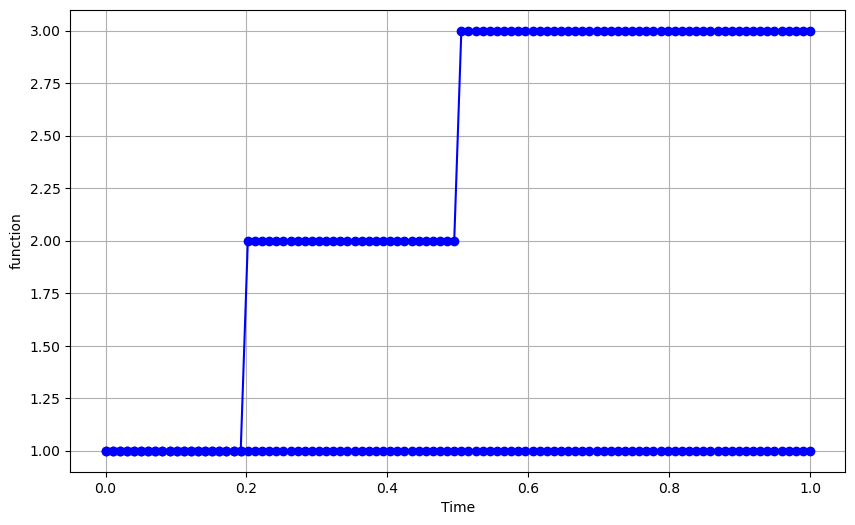

Upper bound objective value: 1.6708494375823342
Newton parameter:  1
Vector standard inner [0.43587377 1.06546921 0.65723502 0.24215209 1.11389963 0.48430418]
Hesse: [[1.45291255e-01 1.45291255e-01 1.24011223e-01 2.06092659e-43
  1.45291255e-01 2.41457671e-43]
 [1.45291255e-01 4.35873766e-01 2.39950710e-01 3.98771003e-43
  4.35873766e-01 7.24373014e-43]
 [1.24011223e-01 2.39950710e-01 1.62250055e-01 2.69641283e-43
  2.42152092e-01 4.02429452e-43]
 [2.06092659e-43 3.98771003e-43 2.69641283e-43 1.62250055e-01
  4.02429452e-43 2.42152092e-01]
 [1.45291255e-01 4.35873766e-01 2.42152092e-01 4.02429452e-43
  4.84304185e-01 8.04858904e-43]
 [2.41457671e-43 7.24373014e-43 4.02429452e-43 2.42152092e-01
  8.04858904e-43 4.84304185e-01]]
norm G:  0.26289439240453116 	q:  [0.43587377 1.06546921 0.65723502 0.24215209 1.11389963 0.48430418] 	point [0.43587377 1.06546921 0.65723502 0.24215209 1.11389963 0.48430418]
norm G:  0.5377906147258061 	q:  [-6.05781058e-01  4.73554737e-02  3.16605166e+00  1.2

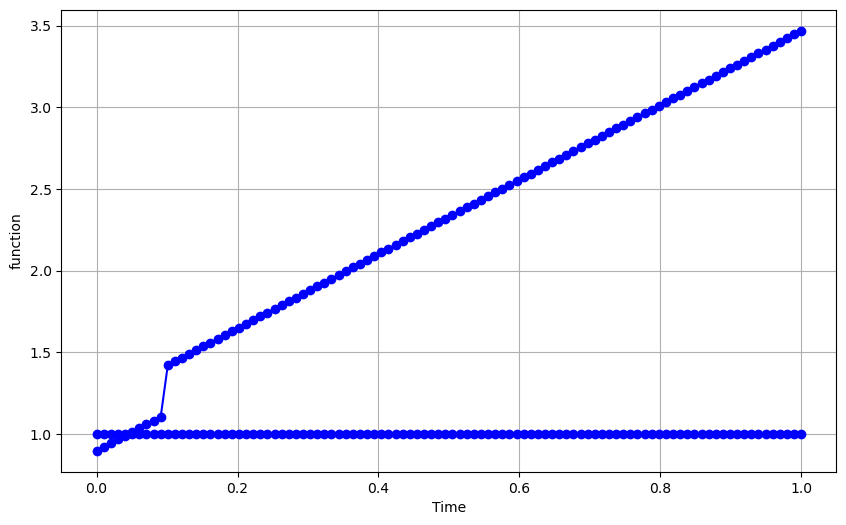

In [16]:
params = Parameters()
# Setup observation
active_set = []
active_set.append(ExtremalPoint(np.array([1, 0]), 0.5, type=0, params=params))
active_set.append(ExtremalPoint(np.array([1, 0]), 0.2, type=0, params=params))
weights = np.ones(len(active_set))
slope = np.zeros((params.d,))
y_shift = np.ones((params.d,))
u_1 = lambda t: buildIterationFunction(t, active_set, weights, slope, y_shift, params)[0]
#u_1 = lambda t: (0.05 if t <= 0.25 else (0.65 if t <= 0.5 else (0.15 if t <= 0.75 else 0.35)))
u_2 = lambda t: buildIterationFunction(t, active_set, weights, slope, y_shift, params)[1]
array = np.ndarray((int(params.T/params.dt), 2))
timePoints = np.linspace(0, params.T, num=int(params.T/params.dt))
array[:, 0] = np.array([u_1(t) for t in timePoints])
array[:, 1] = np.array([u_2(t) for t in timePoints])
plot_array(array, params.T)
g1 = getSourceTerm(params.x1, params)
g2 = getSourceTerm(params.x2, params)
params.yd = buildControlFunction([g1, g2], [u_1, u_2], params)
#timeDependentVariableToGif(params.yd, '../output/observation.gif', slowMoFactor=2, T=params.T)
# Setup solver
params.newton_c = 1
params.maxNewtonSteps = 40
params.alpha = 2e-4
slope = np.zeros((params.d,))
y_shift = np.zeros((params.d,))
active_set = []
active_set.append(ExtremalPoint(np.array([1, 0]), 0.7, type=0, params=params))
active_set.append(ExtremalPoint(np.array([1, 0]), 0.1, type=0, params=params))
weights = np.zeros(len(active_set))
hesseMatrix = HesseMatrix(active_set, params)
print('Upper bound objective value:', computeObjective(np.concatenate((weights, slope, y_shift)), active_set, hesseMatrix.standard_states, params))
#print('cond: ', np.linalg.cond(hesseMatrix.matrix))
#timeDependentVariableToGif(params.yd, 'output/observation.gif', slowMoFactor=2, T=params.T)
#weights[:] = 0
print('Newton parameter: ', params.newton_c)
#print(hesseMatrix.matrix)
weights, slope, y_shift = computeSSNStepWalter(weights, slope, y_shift, active_set, hesseMatrix, params)
#weights_new, slope_new, y_shift_new = computeOSQPStep(weights, slope, y_shift, active_set, hesseMatrix, params)
print(f'weights with dt={params.dt}: ', np.concatenate((weights, slope, y_shift)))
print('Objective:', computeObjective(np.concatenate((weights, slope, y_shift)), active_set, hesseMatrix.standard_states, params))

u_1 = lambda t: buildIterationFunction(t, active_set, weights, slope, y_shift, params)[0]
u_2 = lambda t: buildIterationFunction(t, active_set, weights, slope, y_shift, params)[1]
array = np.ndarray((int(params.T/params.dt), 2))
timePoints = np.linspace(0, params.T, num=int(params.T/params.dt))
array[:, 0] = np.array([u_1(t) for t in timePoints])
array[:, 1] = np.array([u_2(t) for t in timePoints])
plot_array(array, params.T)